# GSM_SVM
## Prepare traning and testing datasets
### Get positive sequence

In [2]:
hg38_fa = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta'
path = '/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac'
code_path = '/home/lis262/Code/Scripts/HPC_Scripts/epigenetics'
svm_path = f'{path}/p01_gkm_svm'
os.makedirs(svm_path,exist_ok=True)
cell_peak_path = f'{path}/f04_cell_peak'

In [ ]:
# get positive sequence
cell_peak_fns = sorted(glob.glob(f'{cell_peak_path}/adult/*.bed.gz'))
pos_seq_code = f'{code_path}/utils/m01_get_positive_sequence.py'
for cell_peak_fn in cell_peak_fns:
    cell = os.path.basename(cell_peak_fn)[:-7]
    cell_path = f'{svm_path}/{cell}'
    os.makedirs(cell_path,exist_ok=True)
    cmd = f'python {pos_seq_code} -r {hg38_fa} -p {cell_peak_fn} --path {cell_path}'
    log = f'{cell_path}/positive_seq.log'
    bsub = f'bsub -M 21457280 -o {log} -q medium \"{cmd}\"'
    if not os.path.exists(log): 
        pass
        os.system(bsub)
#         print(bsub)

### Get negative sequence

In [30]:
# get negative sequence
neg_seq_code = f'{code_path}/utils/m02_get_negative_sequence.py'
chr_size_fn = f'{path}/hg38.chrom.sizes.txt'
for cell_peak_fn in cell_peak_fns[0:1]:
    cell = os.path.basename(cell_peak_fn)[:-7]
    cell_path = f'{svm_path}/{cell}'
    os.makedirs(cell_path,exist_ok=True)
    log = f'{cell_path}/neg_log.txt'
    cmd = f'python {neg_seq_code} -r {hg38_fa} -p {cell_peak_fn} \
            -c {chr_size_fn} --path {cell_path} -f 10 \
          --neg {code_path}/svm_training/gc_dinuc_balanced/gen_dinucleotide_freqs.py'
    bsub = f'bsub -M 21457280 -o {log} -q medium \"{cmd}\"'
    print(cmd)
    os.system(bsub)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/m02_get_negative_sequence.py -r /hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/f04_cell_peak/adult/ACardiomyocyte.bed.gz             -c /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/hg38.chrom.sizes.txt --path /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p01_gkm_svm/ACardiomyocyte -f 10           --neg /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/svm_training/gc_dinuc_balanced/gen_dinucleotide_freqs.py
Job <10408293> is submitted to queue <medium>.


## Train the model using lsgvm

In [38]:
# train the model
t = 9
code = f'{code_path}/utils/m03_train_gkm_svm.py'
for cell_peak_fn in cell_peak_fns[0:1]:
    cell = os.path.basename(cell_peak_fn)[:-7]
    cell_path = f'{svm_path}/{cell}'
    os.makedirs(cell_path,exist_ok=True)
    log = f'{cell_path}/train_log.txt'
    cmd = f'python {code} -p {cell_path}'
    # bsub = f'bsub -n {t} -R \"span[ptile={t}]\" -M 35457280 -o {log} \
               # -q medium \"{cmd}\"'
    print(cmd)
    os.system(cmd)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/m03_train_gkm_svm.py -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p01_gkm_svm/ACardiomyocyte
Job <10410236> is submitted to queue <long>.
Job <10410237> is submitted to queue <long>.
Job <10410238> is submitted to queue <long>.
Job <10410239> is submitted to queue <long>.
Job <10410240> is submitted to queue <long>.


## Test the model

In [ ]:
# test the model
code = '/home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/m04_test_gkm_svm.py'
for i in range(0,1):
    log = f'{path}/p01_gkm_svm/ACardiomyocyte/fold{i}/log{i}.txt'
    cmd = f'python {code} {i}'
    bsub = f'bsub -q short -o {log} \"{cmd}\"'
    # print(cmd)
    # os.system(cmd)
    print(bsub)

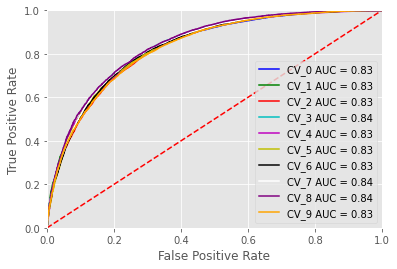

In [231]:
# plot ROC curve
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import scikitplot as skplt
import numpy as np

fig = plt.figure()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

color = ['b','g','r','c','m','y','k','w','purple','orange']
for i in range(10):
    fold_path = f'{path}/p01_gkm_svm/ACardiomyocyte/fold{i}'
    pos_fn = f'{fold_path}/predict_test_pos.txt'
    neg_fn = f'{fold_path}/predict_test_neg.txt'
    pos_df = pd.read_csv(pos_fn,sep='\t',names=['seq','score'])
    pos_df['true'] = 1 
    neg_df = pd.read_csv(neg_fn,sep='\t',names=['seq','score'])
    neg_df['true'] = 0 
    test_df = pd.concat([pos_df, neg_df])
    fpr, tpr, threshold = metrics.roc_curve(test_df['true'], test_df['score'])
    roc_auc = round(metrics.auc(fpr, tpr),2)
    # 
    plt.plot(fpr, tpr, color[i], label = f'CV_{i} AUC = {roc_auc}')
    plt.legend(loc = 'lower right')

## Delta SVM to predict variant effect on the chromatin openess

In [256]:
import pysam
import pandas as pd
from pybedtools import BedTool
def get_int_pos(pos):
    try:
        val = int(pos)
        return True
    except:
        return False

hg38_fa = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta'
ref = pysam.FastaFile(hg38_fa)

gwas_path = f'{path}/gwas'
gwas_fn = f'{gwas_path}/Lung_GWAS_20210629.tsv'
gwas_df = pd.read_csv(gwas_fn, sep='\t', header=0, low_memory=False)
gwas_df = gwas_df[gwas_df['CHR_POS'].map(lambda x: get_int_pos(x))]
gwas_df['start'] = gwas_df['CHR_POS'].astype('int') - 1
gwas_df['CHR_ID'] = 'chr' + gwas_df['CHR_ID'].astype('str')
print('raw snps', gwas_df.shape[0])

peak_fn = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/epigenetics/gkm_svm/model/alveolar_peak.bed'
peak_df = pd.read_csv(peak_fn,sep='\t',header=None)

gwas_bed = BedTool.from_dataframe(gwas_df[['CHR_ID','start','CHR_POS','STRONGEST SNP-RISK ALLELE']])
peak_bed = BedTool.from_dataframe(peak_df[[0, 1, 2]])
gwas_df = gwas_bed.intersect(peak_bed, wa = True).to_dataframe()
print('number of snps in peask', gwas_df.shape[0])
# output the sequence
risk_fa = gwas_fn[:-3] + 'risk_50.fa'
norm_fa = gwas_fn[:-3] + 'norm_50.fa'
offset = 50
with open(risk_fa,'w') as riskh, open(norm_fa, 'w') as normh:
    for idx, row in gwas_df.iterrows():
        chrom = str(row['chrom'])
        pos = int(row['start'])
        ref_snp = ref.fetch(chrom, pos, pos+1)
        risk_seq = ref.fetch(chrom, pos-offset, pos+offset)
        snp, risk = row['name'].split('-')
        if risk == '?':
            continue
        norm_seq = risk_seq[:499] + risk + risk_seq[500:]
        riskh.write(f'>{snp}_{ref_snp}_{risk}\n{risk_seq}\n')
        normh.write(f'>{snp}_{ref_snp}_{risk}\n{norm_seq}\n')

raw snps 893
number of snps in peask 39


In [226]:
### create the pipeline for delta-SVM
code = '/home/lis262/Code/Scripts/HPC_Scripts/epigenetics/m05_gkm_svm_predict_kmer.py'
for i in range(10):
    log = f'{path}/model/fold{i}/log{i}.txt'
    cmd = f'bsub -q medium -o {log} \"python {code} {i}\"'
#     print(cmd)
    os.system(cmd)

In [229]:
### run delta svm
code = '/home/lis262/Code/Scripts/HPC_Scripts/epigenetics/m06_run_delta_svm.py'
for i in range(10):
    log = f'{path}/model/fold{i}/log{i}.txt'
    cmd = f'bsub -o {log} \"python {code} {i}\"'
#     print(cmd)
    os.system(cmd)

In [245]:
# merge delta score
delta_fns = sorted(glob.glob(f'{path}/model/fold*/predict_delta_svm.txt'))
delta_dfs = []
for fn in delta_fns:
    df = pd.read_csv(fn,sep='\t',header=None, names=['score'],index_col=0)
    delta_dfs.append(df)
delta_df = pd.concat(delta_dfs,axis=1)
delta_df['mean'] = delta_df.mean(axis=1)

# scEpiLock
## prepair input
### get positive seqeunce

In [3]:
# get positive sequence
epi_path = f'{path}/p02_scEpiLock'
os.makedirs(epi_path,exist_ok=True)
cell_peak_fns = sorted(glob.glob(f'{cell_peak_path}/adult/*.bed.gz'))
pos_seq_code = f'{code_path}/utils/m01_get_positive_sequence.py'
for cell_peak_fn in cell_peak_fns[2:]:
    cell = os.path.basename(cell_peak_fn)[:-7]
    cell_path = f'{epi_path}/{cell}'
    os.makedirs(cell_path,exist_ok=True)
    cmd = f'python {pos_seq_code} -r {hg38_fa} -p {cell_peak_fn} --path {cell_path} -f 1'
    log = f'{cell_path}/positive_seq.log'
    bsub = f'bsub -M 21457280 -o {log} -q medium \"{cmd}\"'
    # print(bsub)
    if not os.path.exists(log): 
        pass
        # os.system(cmd)
        # print(bsub)
        # os.system(bsub)

### get negative sequence

In [4]:
# get negative sequence
neg_seq_code = f'{code_path}/utils/m02_get_negative_sequence.py'
chr_size_fn = f'{path}/hg38.chrom.sizes.txt'
fold = 1
for cell_peak_fn in cell_peak_fns:
    cell = os.path.basename(cell_peak_fn)[:-7]
    cell_path = f'{epi_path}/{cell}'
    os.makedirs(cell_path,exist_ok=True)
    log = f'{cell_path}/neg_log.txt'
    if not os.path.exists(log):
        cmd = f'python {neg_seq_code} -r {hg38_fa} -p {cell_peak_fn} \
                -c {chr_size_fn} --path {cell_path} -f {fold} \
              --neg {code_path}/svm_training/gc_dinuc_balanced/gen_dinucleotide_freqs.py'
        bsub = f'bsub -M 21457280 -o {log} -q medium \"{cmd}\"'
        # print(cmd)
        # os.system(bsub)
        # os.system(cmd)

### Merge for positive and negative sequence

In [186]:
code = f'{code_path}/utils/e01_get_pos_neg4epi_lock.py'
for cell_peak_fn in cell_peak_fns[2:]:
    for f in range(1):
        cell = os.path.basename(cell_peak_fn)[:-7]
        cell_path = f'{epi_path}/{cell}'
        fold_path = f'{cell_path}/fold{f}'
        os.makedirs(fold_path,exist_ok=True)
        log = f'{cell_path}/merge_pos_neg_log.txt'
        cmd = f'python {code} -p {fold_path}'
        print(cmd)
        # os.system(cmd)
        # bsub = f'bsub -o {log} -q medium  \"{cmd}\"'
        # print(bsub)
        # os.system(bsub)

## Generate the model
### train and test the model

In [337]:
# train the model
code = f'{code_path}/utils/e02_train_scEpiLock.py'
for cell_peak_fn in cell_peak_fns[56:57]:
    for f in range(1):
        cell = os.path.basename(cell_peak_fn)[:-7]
        cell_path = f'{epi_path}/{cell}'
        fold_path = f'{cell_path}/fold{f}'
        log = f'{cell_path}/train_log.txt'
        cmd = f'python {code} -p {fold_path}'
        print(cmd)
        # os.system(cmd)
        # bsub = f'bsub -m \"hpcgpu101\" -o {log} -q medium  \"{cmd}\"'
        # print(bsub)
        # os.system(bsub)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/e02_train_scEpiLock.py -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p02_scEpiLock/Keratinocyte1/fold0


#### check AUC for all cell types

In [5]:
metric_dfs = []
for cell_peak_fn in cell_peak_fns:
    for f in range(1):
        cell = os.path.basename(cell_peak_fn)[:-7]
        cell_path = f'{epi_path}/{cell}'
        fold_path = f'{cell_path}/fold{f}'
        metric_fn = f'{fold_path}/binary_perf_metrics.csv'
        try:
            metric_df = pd.read_csv(metric_fn,sep=',',header=0,index_col=0,names=['train',cell])
            metric_dfs.append(metric_df[cell])
        except:
            pass

all_metric_df = pd.concat(metric_dfs,axis=1).T
all_metric_fn = f'{path}/scEpiLock_metrics.tsv'
all_metric_df.to_csv(all_metric_fn,sep='\t',index=False)

<AxesSubplot:>

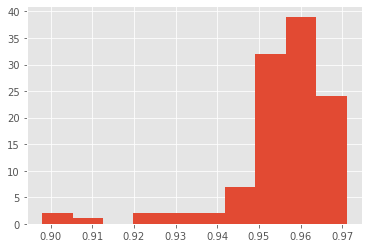

In [6]:
all_metric_df['AUC'].hist()

In [7]:
all_metric_df.query('AUC < 0.8') 

,AUC,AUPRC,Accuracy,Precision,Recall,f1-score


### Detect peak boundary

In [ ]:
code = f'{code_path}/utils/e03_peak_boundary.py'
for cell_peak_fn in cell_peak_fns:
    for f in range(1):
        cell = os.path.basename(cell_peak_fn)[:-7]
        cell_path = f'{epi_path}/{cell}'
        fold_path = f'{cell_path}/fold{f}'
        log = f'{cell_path}/train_log.txt'
        cmd = f'python {code} -p {fold_path}'
        print(cmd)
        # os.system(cmd)
        bsub = f'bsub -m \"hpcgpu101\" -o {log} -q medium  \"{cmd}\"'
        # print(bsub)
        # os.system(bsub)

### Summarize ROC curve for all cell types

In [8]:
train_roc_curve = []
test_roc_curve = []
for cell_peak_fn in cell_peak_fns:
    for f in range(1):
        cell = os.path.basename(cell_peak_fn)[:-7]
        cell_path = f'{epi_path}/{cell}'
        roc_fn = f'{cell_path}/fold0/binary_perf_metrics.csv'
        roc_df = pd.read_csv(roc_fn,header=0,index_col=0)
        train = roc_df.loc['AUC','train']
        train_roc_curve.append(train)
        test = roc_df.loc['AUC','test']
        test_roc_curve.append(test)
        # print(cell,'train',train,'test',test)

Text(0.5, 1.0, 'test AUC values')

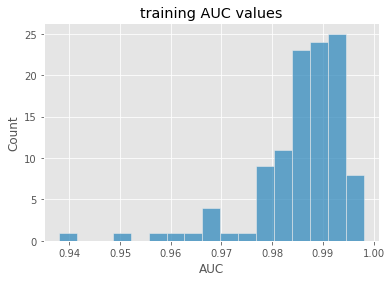

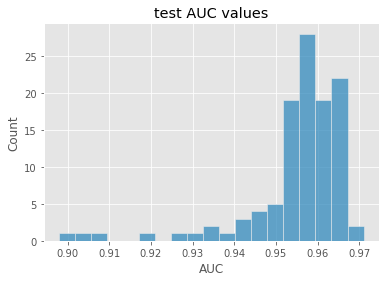

In [9]:
ax = sns.histplot(data=train_roc_curve)
ax.set_xlabel('AUC')
ax.set_title('training AUC values')
plt.figure()
ax = sns.histplot(data=test_roc_curve)
ax.set_xlabel('AUC')
ax.set_title('test AUC values')

### Predict SNP effect on chromatin activity
#### Prepare SNP file
In the human atlas scATACseq paper TableS5, they have listed all of the potential causal SNPs with finemapping PPA > 0.1. We can predict the effect of those variants using our model.

In [ ]:
import myvariant
def get_snp(row):
    '''get hg38 position for table s5'''
    rsid = row['rsid']
    r_ref, r_alt = row['snp_hg19'].split(':')[-2:]
    mv = myvariant.MyVariantInfo()
    res = mv.query(rsid,scopes='dbsnp.rsid',assembly='hg38',
             fields=['dbsnp.chrom','hg38.start','dbsnp.pos','dbsnp.ref','dbsnp.alt'])
    for r in res['hits']:
        try:
            chrom = 'chr' + r['dbsnp']['chrom']
            pos  = r['hg38']['start']
            ref = r['dbsnp']['ref']
            alt = r['dbsnp']['alt']
            if ref == r_ref and alt == r_alt:
                return pd.Series([chrom, pos, ref, alt])
        except:
            break
    return pd.Series(['-']*4)

causal_snp_fn = f'{path}/f06_causal_variants/human_atlas_table_s5_snp.tsv'
causal_snp_df = pd.read_csv(causal_snp_fn,sep='\t',header=0)
causal_snp_df[['chr','hg38_pos','ref','alt']] = causal_snp_df.apply(lambda x:
                get_snp(x),axis=1)
# gwas_catalog_df.to_csv(gwas_catalog_fn,sep='\t',index=False)

Get snp files whose peaks are from the human atlas paper

In [95]:
# make snp file overlapping with human atlas peaks
causal_snp_path = f'{path}/f06_causal_variants'
causal_snp_fn = f'{causal_snp_path}/human_atlas_table_s5_snp.tsv'
causal_snp_df = pd.read_csv(causal_snp_fn,sep='\t',header=0)
causal_snp_df = causal_snp_df.query('cre_hg38 !="." and hg38_pos != "-"')
causal_snp_df['peak_s'] = causal_snp_df['cre_hg38'].map(lambda x: x.split(':')[-1].split('-')[0])
causal_snp_df['peak_s'] = causal_snp_df['peak_s'].astype(int) - 300
causal_snp_df['peak_e'] = causal_snp_df['cre_hg38'].map(lambda x: x.split(':')[-1].split('-')[1])
causal_snp_df['peak_e'] = causal_snp_df['peak_e'].astype(int) + 300
causal_snp_df['hg38_s'] = causal_snp_df['hg38_pos'].astype(int) - 1
snp_fn = f'{causal_snp_path}/snp_atlas_peak.tsv'
causal_snp_df[['chr','peak_s','peak_e','chr','hg38_s','hg38_pos','rsid','alt','ref']]\
     .to_csv(snp_fn,sep='\t',header=None,index=False)

Get snp files whose peaks are centered at SNPs

In [10]:
# make snp file overlapping with human atlas peaks
causal_snp_path = f'{path}/f06_causal_variants'
causal_snp_fn = f'{causal_snp_path}/human_atlas_table_s5_snp.tsv'
causal_snp_df = pd.read_csv(causal_snp_fn,sep='\t',header=0)
causal_snp_df = causal_snp_df.query('cre_hg38 !="." and hg38_pos != "-"')
causal_snp_df['hg38_s'] = causal_snp_df['hg38_pos'].astype(int) - 1
causal_snp_df['peak_s'] = causal_snp_df['hg38_pos'].astype(int) - 500
causal_snp_df['peak_e'] = causal_snp_df['hg38_pos'].astype(int) + 500
snp_fn = f'{causal_snp_path}/snp_atlas_center.tsv'
causal_snp_df[['chr','peak_s','peak_e','chr','hg38_s','hg38_pos','rsid','alt','ref']]\
     .to_csv(snp_fn,sep='\t',header=None,index=False)

#### Predict SNP effect on chromatin openess
predict SNPs overlapping with peaks that are from the human atlas paper

In [11]:
code = f'{code_path}/utils/e04_variant_impact.py'
causal_snp_path = f'{path}/f06_causal_variants'
ref_fa = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta'
model_fns = sorted(glob.glob(f'{path}/p03_cell_model/*.pt'))
snp_bed = f'{causal_snp_path}/snp_atlas_peak.tsv'
out_path = f'{causal_snp_path}/snp_atlas_peak'
os.makedirs(out_path,exist_ok=True)
with open(f'{out_path}/cmd.sh','w') as f: 
    for model in model_fns:
        cell = model.split('/')[-1].split('.')[0]
        cell_path = f'{out_path}/{cell}'
        os.makedirs(cell_path,exist_ok=True)
        cmd = f'python {code} -m {model} -s {snp_bed} -r {ref_fa} -o {cell_path}/{cell}.txt'
        log = f'{cell_path}/log.txt'
        bsub = f'bsub -o {log} \"{cmd}\"'
        f.write(cmd + '\n')
    # os.system(cmd)
    # print(cmd)

Predict SNPs overlapping with peaks centered at SNPs

In [162]:
code = f'{code_path}/utils/e04_variant_impact.py'
ref_fa = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta'
model_fns = sorted(glob.glob(f'{path}/p03_cell_model/*.pt'))
snp_bed = f'{causal_snp_path}/snp_atlas_center.tsv'
out_path = f'{causal_snp_path}/snp_atlas_center_at_snp'
os.makedirs(out_path,exist_ok=True)

with open(f'{out_path}/cmd.sh','w') as f: 
    for model in model_fns:
        cell = model.split('/')[-1].split('.')[0]
        cell_path = f'{out_path}/{cell}'
        os.makedirs(cell_path,exist_ok=True)
        cmd = f'python {code} -m {model} -s {snp_bed} -r {ref_fa} -o {cell_path}/{cell}.txt'
        log = f'{cell_path}/log.txt'
        bsub = f'bsub -o {log} \"{cmd}\"'
        f.write(cmd + '\n')
    # os.system(cmd)
    # print(cmd)

#### Analyze atlas causal variants overalpping with cCREs

In [12]:
# merge the prediction results for all cell types
res_path = f'{path}/f06_causal_variants/snp_atlas_center_at_snp'
res_fns = sorted(glob.glob(f'{res_path}/*/*_model.txt'))
res_dfs = []
for res in res_fns:
    cell = res.split('/')[-1][:-10]
    df = pd.read_csv(res,sep='\t',header=0)
    df = df.drop_duplicates()
    df['cell'] = cell
    res_dfs.append(df)
res_df = pd.concat(res_dfs)

In [16]:
def get_max(row):
    mut = max(row['mut_fwd'], row['mut_fwd.1'])
    wt = max(row['wt_fwd'], row['wt_rev'])
    return mut - wt
res_df['diff_max'] = res_df.apply(lambda x:get_max(x), axis=1)

In [19]:
res_df.query('cell=="ColonEpithelial3"').shape

(2590, 20)

Text(0.5, 1.0, 'distribution of changes of ColonEpithelial3 cell chromatin activity')

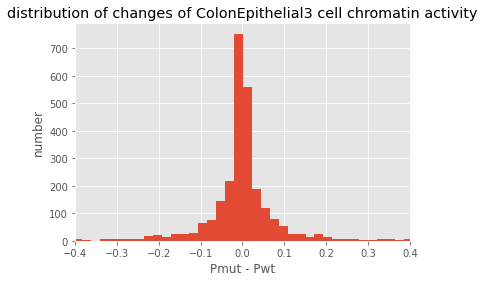

In [17]:
ax = res_df.query('cell=="ColonEpithelial3"')['diff_max'].hist(bins=50)
ax.set_xlim([-0.4, 0.4])
ax.set_xlabel('Pmut - Pwt')
ax.set_ylabel('number')
ax.set_title('distribution of changes of ColonEpithelial3 cell chromatin activity')

In [188]:
from collections import defaultdict
rsid_cell_score = defaultdict(dict)
for idx, row in res_df.iterrows():
    cell = row['cell']
    rsid = row['rsid']
    rsid_cell_score[rsid][cell] = row[9:18]

In [198]:
import re
def rename_cells(cell):
    cell = re.sub(' ','',cell)
    cell = re.sub('/','or',cell)
    cell = re.sub('[()]','_',cell)
    cell = re.sub('AlveolarType2orImmune','AlveolarType2_Immune_',cell)
    cell = re.sub('EndothelialGeneral3','AlveolarType2_Immune_',cell)
    return cell

# read causal genes
causal_snp_path = f'{path}/f06_causal_variants'
causal_snp_fn = f'{causal_snp_path}/human_atlas_table_s5_snp.tsv'
causal_snp_df = pd.read_csv(causal_snp_fn,sep='\t',header=0)
causal_snp_df = causal_snp_df.query('cre_hg38 != "."')
causal_snp_df['top3cells'] = causal_snp_df['top3cells'].map(lambda x:rename_cells(x))

In [221]:
def get_score(row, rsid_cell_score,key):
    '''get open score for top3 open cells'''
    cells = row['top3cells'].split(',')
    rsid = row['rsid']
    scores = []
    for c in cells:
        try:
            scores.append(str(round(rsid_cell_score[rsid][c][key],4))[:5])
        except:
            scores.append('-')
    return ','.join(scores)
    
causal_snp_df['top3cells_wt_mean'] = causal_snp_df.apply(lambda x:get_score(x,rsid_cell_score,'wt_mean'),axis=1)
causal_snp_df['top3cells_mut_mean'] = causal_snp_df.apply(lambda x:get_score(x,rsid_cell_score,'mut_mean'),axis=1)
causal_snp_df['top3cells_diff_mean'] = causal_snp_df.apply(lambda x:get_score(x,rsid_cell_score,'diff_mean'),axis=1)

In [214]:
def get_top_cell_scores(row, res_df):
    '''key should be diff_mean'''
    res_df['diff_mean_abs'] = res_df['diff_mean'].abs()
    key = 'diff_mean_abs'
    rsid = row['rsid']
    sub_df = res_df.query('rsid == @rsid').sort_values(key,ascending=False)
    cells = ','.join(sub_df['cell'][:3])
    wt_scores = ','.join([str(round(s,4)) for s in sub_df['wt_mean'][:3]])
    mut_scores = ','.join([str(round(s,4)) for s in sub_df['mut_mean'][:3]])
    diff_scores = ','.join([str(round(s,4)) for s in sub_df['diff_mean'][:3]])
    return pd.Series([cells, wt_scores, mut_scores,diff_scores])
causal_snp_df[['top3change_cells','top3change_wt_mean','top3change_mut_mean','top3change_diff_mean']] = \
causal_snp_df.apply(lambda x:get_top_cell_scores(x,res_df),axis=1)
causal_snp_df.to_csv(f'{causal_snp_path}/causal_prediction.tsv',sep='\t',index=False)

In [2]:
# read atlas and QTL cell type overlap
atac_qtl_path = f'{path}/atac/f07_QTL_base'
atlas_qtl_cell_fn = f'{atac_qtl_path}/cell_map.tsv'
atlas_qtl_cell_df = pd.read_csv(atlas_qtl_cell_fn, sep='\t', header=0)

In [37]:
# read qtlbase meta data
qtlbase_fn = qtl_path + '/QTLbase/QTLbase_LinDA_meta.tsv'
qtlbase_df = pd.read_csv(qtlbase_fn,sep='\t',header=0)

In [38]:
atlas_cell_src_id_dic = {}
for idx, row in atlas_qtl_cell_df.iterrows():
    qtl_cell = row['QTLbase']
    atl_cell = row['scAtlas']
    src_ids = qtlbase_df.query('Tissue == @qtl_cell')['Sourceid'].tolist()
    for i in src_ids:
        atlas_cell_src_id_dic[i] = atl_cell

In [120]:
def get_cell_qtl(atlas_qtl_cell_df, qtl_path, atac_qtl_path):
    # extract cell specific QTL results
    atl_cells = atlas_qtl_cell_df['scAtlas'].tolist()
    cell_handle_dic = {}
    os.makedirs(f'{atac_qtl_path}/hg19', exist_ok=True)
    for cell in atl_cells:
        cell_handle_dic[cell] = open(f'{atac_qtl_path}/hg19/{cell}_qtl.tsv', 'w')
    qtl_fn = f'{qtl_path}/QTLbase/eQTL.gz'
    with gzip.open(qtl_fn, 'rt') as f:
        head = f.readline()
        for k,v in cell_handle_dic.items():
            v.write(head)
        for line in f:
            items = line.strip().split('\t')
            if items[-1] in atlas_cell_src_id_dic:
                cell_handle_dic[atlas_cell_src_id_dic[items[-1]]].write(line)
    for k,v in cell_handle_dic.items():
        v.close()
get_cell_qtl(atlas_qtl_cell_df, qtl_path, atac_qtl_path)

In [10]:
#================ #liftover to hg38
# container = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/container/crossmap4gwas_0.6.v2.sif'
# cell_qtl_fns = sorted(glob.glob(f'{atac_qtl_path}/hg19/*.tsv'))
# os.makedirs(f'{atac_qtl_path}/hg38',exist_ok=True)
# for f in cell_qtl_fns:
#     cell = f.split('/')[-1].split('.')[0]
#     out = f'{atac_qtl_path}/hg38/{cell}.tsv'
#     cmd = f'singularity run -B /:/media {container} python /media/home/lis262/Code/Pipeline/GWAS/liftover/crossmap_gwas_summary.py -i {f} -o {out} -t {atac_qtl_path}/hg38/tmp \
#           -c SNP_chr -p SNP_pos --conversion 37to38 --add_end yes'
#     # os.system(cmd)

In [121]:
def add_snp_info(row, tb):
    '''get rsid and ref and alt'''
    chrom = row['SNP_chr']
    pos = int(row['SNP_pos'])
    rsids = []; refs = []; alts = []
    try:
        rsid = '-'; ref = '-'; alt = '-'
        records = tb.query(f'{chrom}', pos-1, pos)
        for record in records:
            rsid, ref, alt = record[2:5]
            rsids.append(rsid)
            refs.append(ref)
            alts.append(alt)
    except:
        pass
    return pd.Series([rsids, refs, alts])

In [ ]:
# add rsid and ref and alt  
import tabix
dbsnp = '/hpc/grid/wip_drm_targetsciences/projects/dbsnp/b151/dbSNP.151.GRCh37p13/VCF/dbSNP.151.all.GRCh37.vcf.gz'
tb = tabix.open(dbsnp)
cell_qtl_fns = sorted(glob.glob(f'{atac_qtl_path}/hg19/*_qtl.tsv'))
for f in cell_qtl_fns[-1:]:
    df = pd.read_csv(f,sep='\t',header=0)
    df = df.loc[df.groupby(['SNP_chr','SNP_pos'])['Pvalue'].idxmin()].reset_index(drop=True)
    columns = df.columns.tolist()
    df[['rsid','ref','alt']] = df.apply(lambda x: add_snp_info(x, tb),axis=1)
    df = df.explode(['rsid','ref','alt'])
    out = f[:-8] + '_anno.tsv'
    df.to_csv(out, sep='\t', index=False)

In [130]:
# prepare the SNP file for prediction
cell_qtl_fns = sorted(glob.glob(f'{atac_qtl_path}/hg19/*_anno.tsv'))
for f in cell_qtl_fns:
    df = pd.read_csv(f,sep='\t',header=0)
    df['SNP_start'] = df['SNP_pos'] - 1
    df['peak_s'] = df['SNP_start'] - 500
    df['peak_e'] = df['SNP_start'] + 500
    df[['SNP_start','SNP_pos','peak_s','peak_e']] = df[['SNP_start','SNP_pos','peak_s','peak_e']].astype(int)
    out = f[:-9] + '_4pred.tsv'
    df[['SNP_chr','SNP_start','SNP_pos','SNP_chr','peak_s','peak_e','rsid','alt','ref']] \
        .to_csv(out,sep='\t',header=None,index=False)

In [ ]:
# predict effect of snp

In [17]:
fn = '/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/GSE184462_metadata.tsv.gz'
df = pd.read_csv(fn,sep='\t',header=0)
df = df[df['Life stage'].values == 'Adult']

In [7]:
import myvariant
def get_snp_hg38(row):
    '''get hg38 position for tcga'''
    rsid = row['marker']
    r_ref, r_alt = row['SNP'].split(':')[-2:]
    mv = myvariant.MyVariantInfo()
    res = mv.query(rsid,scopes='dbsnp.rsid',assembly='hg38',
             fields=['dbsnp.chrom','hg38.start','dbsnp.pos','dbsnp.ref','dbsnp.alt'])
    for r in res['hits']:
        try:
            chrom = 'chr' + r['dbsnp']['chrom']
            pos  = r['hg38']['start']
            ref = r['dbsnp']['ref']
            alt = r['dbsnp']['alt']
            if ref == r_ref and alt == r_alt:
                return pd.Series([chrom, pos, ref, alt])
        except:
            break
    return pd.Series(['-']*4)

In [8]:
tcga_hits = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/tumor/p01_cyto_norm_qtl/f03_qtl/r03_eur_tcga_QTL_anno.tsv'
tcga_df = pd.read_csv(tcga_hits,sep='\t',header=0)
# get hg38 position
tcga_df[['chr','pos','ref','alt']] = tcga_df.apply(lambda x:get_snp_hg38(x),axis=1)

In [10]:
tcga_df.head()

,SNP,cell,beta,t-stat,p-value,marker,REF,ALT,std,cancer,Consequence,near_gene,near_50Kgene,chr,pos,ref,alt
0,2:201713698:C:T,CD14.low._CD16.positive_monocyte,-1.073927,-6.634890,1.493258e-08,rs10179569,C,T,0.161861,ACC,downstream_gene_variant,CLK1,BZW1;NIF3L1;PPIL3;CLK1,chr2,200848975,C,T
1,2:201710305:A:T,CD14.low._CD16.positive_monocyte,-1.069169,-6.579650,1.838154e-08,rs13028326,A,T,0.162496,ACC,upstream_gene_variant,CLK1,BZW1;NIF3L1;PPIL3;CLK1,chr2,200845582,A,T
2,1:10290268:T:C,fat_cell,-0.992598,-6.486930,2.604494e-08,rs17396382,T,C,0.153015,ACC,intron_variant,KIF1B,UBE4B;KIF1B,chr1,10230210,T,C
3,1:214678564:T:C,alternatively_activated_macrophage,-0.925188,-5.626198,4.388278e-08,rs79225222,T,C,0.164443,BLCA,intron_variant,PTPN14,PTPN14,chr1,214505221,T,C
4,1:214678569:G:C,alternatively_activated_macrophage,-0.925097,-5.625532,4.403543e-08,rs77487504,G,C,0.164446,BLCA,intron_variant,PTPN14,PTPN14,chr1,214505226,G,C


In [12]:
tcga_df['cell'].unique()

array(['CD14.low._CD16.positive_monocyte', 'fat_cell',
       'alternatively_activated_macrophage',
       'CD14.positive._CD16.positive_monocyte',
       'naive_thymus.derived_CD4.positive._alpha.beta_T_cell',
       'Cancer_associated_fibroblast_.CAF.', 'regulatory_T_cell',
       'chondrocyte', 'T_follicular_helper_cell', 'memory_B_cell',
       'CD4.positive._alpha.beta_T_cell',
       'CD14.positive._CD16.negative_classical_monocyte',
       'mature_natural_killer_cell', 'dendritic_cell', 'naive_B_cell',
       'central_memory_CD4.positive._alpha.beta_T_cell',
       'T.helper_1_cell', 'myeloid_dendritic_cell', 'epithelial_cell',
       'stromal_cell', 'myofibroblast', 'mature_B_cell',
       'natural_killer_cell', 'clear_cell_renal_cell_carcinoma_cell',
       'class_switched_memory_B_cell',
       'naive_thymus.derived_CD8.positive._alpha.beta_T_cell',
       'hepatocyte', 'respiratory_epithelial_cell', 'ILC1',
       'inflammatory_macrophage', 'fibroblast', 'T.helper_2_cell',
 

In [4]:
import pybedtools
pybedtools.set_tempdir('/lustre/scratch/lis262/pybedtools')
from pybedtools import BedTool

cre_peak_fn = f'{path}/cCRE_hg38.tsv.gz'
peak_df = pd.read_csv(cre_peak_fn, sep='\t',header=0,compression='gzip')
peak_df.index = peak_df['#Chromosome'] + '_' + peak_df['hg38_Start'].astype(str) + '_' + peak_df['hg38_End'].astype(str)
peak_df = peak_df[peak_df['Present in adult tissues'].values=="yes"]
peak_bed = BedTool.from_dataframe(peak_df)
peak_cols = peak_df.columns.tolist()

all_peak_fn = f'{path}/all_peak.tsv.gz'
peak_df[[7,8]] = '.'
peak_df[9] = 200
peak_df.to_csv(all_peak_fn, sep='\t', header=None, index=False, compression='gzip')

In [5]:
cell_peak_cols = ['chr','start','end','name','score','strand','signal','pval','qval','peak']
peak_paths = f'{path}/f04_cell_peak/adult/'
peak_files = sorted(glob.glob(f'{peak_paths}/*bed.gz'))

labels = []
for p in peak_files:
    cell = os.path.basename(p)[:-7]
    df = pd.read_csv(p,sep='\t',header=None,compression='gzip',names=cell_peak_cols)
    bed = BedTool.from_dataframe(df)
    merge_df = peak_bed.intersect(bed,wao=True).to_dataframe(names=peak_cols+cell_peak_cols+['overlap'])
    col = merge_df['overlap'].map(lambda x: '1' if x > 0 else '0')
    col.name = cell
    labels.append(col)
label_df = pd.concat(labels,axis=1)
label_df.index = peak_df.index

# output file
single_model_path = f'{path}/p04_merge_model'
os.makedirs(single_model_path,exist_ok=True)
label_fn = f'{single_model_path}/label.txt'
label_df.index = peak_df.index
label_df.to_csv(label_fn, sep=',',index=False)

## Get positive sequence

In [105]:
# get positive sequence
single_model_path = f'{path}/p04_merge_model'
os.makedirs(single_model_path,exist_ok=True)
all_peak_fn = f'{path}/all_peak.tsv.gz'
pos_seq_code = f'{code_path}/utils/m01_get_positive_sequence.py'

cmd = f'python {pos_seq_code} -r {hg38_fa} -p {all_peak_fn} --path {single_model_path} -f 1 --header yes'
log = f'{single_model_path}/positive_seq.log'
bsub = f'bsub -M 21457280 -o {log} -q medium \"{cmd}\"'
print(cmd)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/m01_get_positive_sequence.py -r /hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/all_peak.tsv.gz --path /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p04_merge_model -f 1 --header yes


## Get negative sequence

In [106]:
# get negative sequence
single_model_path = f'{path}/p04_merge_model'
neg_seq_code = f'{code_path}/utils/m02_get_negative_sequence.py'
chr_size_fn = f'{path}/hg38.chrom.sizes.txt'
fold = 1
all_peak_fn = f'{path}/all_peak.tsv.gz'
log = f'{single_model_path}/neg_log.txt'

cmd = f'python {neg_seq_code} -r {hg38_fa} -p {all_peak_fn} \
                -c {chr_size_fn} --path {single_model_path} -f {fold} \
              --neg {code_path}/svm_training/gc_dinuc_balanced/gen_dinucleotide_freqs.py'
bsub = f'bsub -M 21457280 -o {log} -q medium \"{cmd}\"'
print(cmd)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/m02_get_negative_sequence.py -r /hpc/grid/wip_drm_targetsciences/users/shangzhong/publicDB/gatk_homo38_index/hg38.fasta -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/all_peak.tsv.gz                 -c /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/hg38.chrom.sizes.txt --path /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p04_merge_model -f 1               --neg /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/svm_training/gc_dinuc_balanced/gen_dinucleotide_freqs.py


## Merge positive and negative sequence and update label

In [14]:
code = f'{code_path}/utils/e01_get_pos_neg4epi_lock.py'

all_peak_fn = f'{path}/all_peak.tsv.gz'
all_peak_df = pd.read_csv(all_peak_fn, sep='\t',header=None,compression='gzip')
all_peak_df[1] -= 300
all_peak_df[2] += 300
all_peak_df.index = all_peak_df[0] + '_' + all_peak_df[1].astype(str) + '_' + all_peak_df[2].astype(str)

single_model_path = f'{path}/p04_merge_model'
label_fn = f'{single_model_path}/label.txt'
label_df = pd.read_csv(label_fn, header=0)
label_df.index = all_peak_df.index

In [22]:
for f in range(1):
    fold_path = f'{single_model_path}/fold{f}'
    cmd = f'python {code} -p {fold_path}'
    print(cmd)
    # os.system(cmd)
    # update the positive label
    pos_bed = f'{single_model_path}/fold{f}/pos.bed'
    pos_df = pd.read_csv(pos_bed,sep='\t',header=None)
    pos_df.index = pos_df[0] + '_' + pos_df[1].astype(str) + '_' + pos_df[2].astype(str)
    final_pos_label_df = label_df.loc[pos_df.index,:]
    final_pos_label_df.to_csv(f'{single_model_path}/fold{f}/pos.label',header=None,index=False)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/e01_get_pos_neg4epi_lock.py -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p04_merge_model/fold0


## Generate the model
### train and test the model

In [23]:
# train the model
code = f'{code_path}/utils/e02_train_scEpiLock.py'
single_model_path = f'{path}/p04_merge_model'

for f in range(1):
    fold_path = f'{single_model_path}/fold{f}'
    log = f'{single_model_path}/train_log.txt'
    cmd = f'python {code} -p {fold_path}'
    print(cmd)
    # os.system(cmd)
    # bsub = f'bsub -m \"hpcgpu101\" -o {log} -q medium  \"{cmd}\"'
    # print(bsub)
    # os.system(bsub)

python /home/lis262/Code/Scripts/HPC_Scripts/epigenetics/utils/e02_train_scEpiLock.py -p /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/p04_merge_model/fold0


In [141]:
import glob
import os
from Bio import SeqIO
import gzip
import re
raw_path = '/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/'
fq_path = f'{raw_path}/fastq'
bam_path = f'{raw_path}/bam'
bwa_mem = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/container/gatk4_ppl_4.1.4.1.sif'
bwa_idx = '/hpc/grid/wip_drm_targetsciences/projects/Ensembl/genome/hg19/bwa_index/hg19'
atac_docker = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac'
cell_fq_path = f'{raw_path}/cell_fq'
os.makedirs(cell_fq_path,exist_ok=True)

In [181]:
def reformat_cell(cell):
    # replace () with _
    name = re.sub('[(_)]','_',cell)
    name = re.sub(' ','', name)
    if name.endswith('_'):
        name = name[:-1]
    return name

meta_fn = f'{raw_path}/SRA/meta.tsv'
meta_df = pd.read_csv(meta_fn,sep='\t',header=0)
meta_df['sp_name'] = meta_df['experiment_title'].map(lambda x: x.split(';')[0].split(' ')[-1])
# prepare file with two columns: cell name  and  barcode
barcode_fn = f'{raw_path}/GSE184462_metadata.tsv.gz'
barcode_df = pd.read_csv(barcode_fn,sep='\t',header=0,compression='gzip')

In [182]:
# barcode_df = barcode_df[barcode_df['sample'].map(lambda x:'SM-' in x)]
barcode_df = barcode_df[barcode_df['Life stage'].values=='Adult']
barcode_df['barcode'] = barcode_df['cellID'].map(lambda x: x.split('+')[1])
barcode_sp_dict = barcode_df.set_index('barcode')['sample'].to_dict()
barcode_df['cell type'] = barcode_df['cell type'].map(lambda x: reformat_cell(x))
bc_fn = f'{cell_fq_path}/barcode.txt'
barcode_df[['cell type','barcode']].to_csv(bc_fn,header=None,sep=' ',index=False)
cells = barcode_df['cell type'].unique().tolist()

In [185]:
# demultiplex fastq files into cell type level fq files
fst_files = sorted(glob.glob(f'{fq_path}/*_1.fastq.gz'))
snd_files = sorted(glob.glob(f'{fq_path}/*_2.fastq.gz'))
for fst,snd in zip(fst_files,snd_files):
    srr = os.path.basename(fst).split('_')[0]
    os.makedirs(f'{cell_fq_path}/{srr}',exist_ok=True)
    cmd = f'demultiplex demux -m 4 --format=umi \
             {bc_fn} {fst} {snd} -p {cell_fq_path}/{srr}'
    log = f'{cell_fq_path}/{srr}/log.txt'
    bsub = f'bsub -o {log} -q long  \"{cmd}\"'
    os.system(bsub)

## Merge fq files for each cell

In [167]:
# merge fq files from all samples
for cell in cells:
    fst_fns = sorted(glob.glob(f'{cell_fq_path}/*/*_1_{cell}.fastq.gz'))
    fst_fn = ' '.join(fst_fns)
    cmd = f'cat {fst_fn} > {cell_fq_path}/{cell}_1.fq.gz'
    os.system(cmd)
    # second file 
    snd_fns = sorted(glob.glob(f'{cell_fq_path}/*/*_2_{cell}.fastq.gz'))
    snd_fn = ' '.join(snd_fns)
    cmd = f'cat {snd_fn} > {cell_fq_path}/{cell}_2.fq.gz'
    os.system(cmd)

## Prepare intput files for feature extraction
### Align reads to hg19

In [65]:
fst_files = sorted(glob.glob(f'{cell_fq_path}/*_1.fq.gz'))
snd_files = sorted(glob.glob(f'{cell_fq_path}/*_2.fq.gz'))
t = 9
for fst, snd in zip(fst_files, snd_files):
    bam_fn = f'{bam_path}/' + fst.split('/')[-1][:-6] + '.bam'
    pre = f'{bam_fn}.pre'
    cmd = f'singularity run -B /:/media {bwa_mem} \
            bwa mem -t {t} /media/{bwa_idx} /media/{fst} /media/{snd} | \
            samtools sort -@ {t} -T {pre} -o {bam_fn} - && \
            samtools index {bam_fn}'
    log = f'{bam_fn}.log'
    bsub = f'bsub -q short -n {t}  -M 21457280 -R "span[ptile={t}]" -o {log} "{cmd}"'
    os.system(bsub)
#     print(bsub)

### Prepare chromosoem fasta file

In [60]:
from Bio import SeqIO
genome_path = '/hpc/grid/wip_drm_targetsciences/projects/Ensembl/genome/hg19'
hg19_fa = f'{genome_path}/hg19.fa'
hg19_idx = SeqIO.index(hg19_fa,'fasta')
chroms = [f'chr{i}' for i in range(1,23)] + ['chrX', 'chrY']
for c in chroms:
    out_fa = f'{genome_path}/hg19_chr/{c}.fa'
    SeqIO.write(hg19_idx[c],out_fa,'fasta')
    cmd = f'gzip {out_fa}'
    os.system(cmd)

In [63]:
# create a file with two columns:  chrome   filepath
chrom_fn = f'{raw_path}/chrom_fa.txt'
chrom_fas = sorted(glob.glob(f'{genome_path}/hg19_chr/*.fa.gz'))
with open(chrom_fn,'w') as f:
    for fa in chrom_fas:
        chrom = fa.split('/')[-1].split('.')[0]
        f.write('\t'.join([chrom,fa])+'\n')

### liftover peak file to hg19

In [77]:
crossmap = '/hpc/grid/wip_drm_targetsciences/users/shangzhong/container/crossmap4gwas_0.6.v2.sif'
bed38 = '/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/peak_38/GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments.bed.gz'
bed19 = '/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/peak_19/GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments.bed'
cmd = f'singularity run -B /:/media/ {crossmap} CrossMap.py bed \
          /GRCh38_to_GRCh37.chain.gz  /media/{bed38} /media/{bed19} && \
          bgzip /media/{bed19}'
os.system(cmd)

0

## Run Feature extraction

In [70]:
bam_fns = sorted(glob.glob(f'{bam_path}/*.bam'))
pred_path = f'{atac_docker}/core_atac_predictor_hg19'
pred_sh = f'{atac_docker}/CoRE-ATAC/FeatureExtractor.sh'
for bam in bam_fns:
    peak_fn = ''
    feature_path = f'singularity exec {pred_path} {pred_sh} {bam}'
    print(feature_path)

singularity exec /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/core_atac_predictor_hg19 /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/CoRE-ATAC/FeatureExtractor.sh /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac//bam/SRR15999465.bam
singularity exec /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/core_atac_predictor_hg19 /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/CoRE-ATAC/FeatureExtractor.sh /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac//bam/SRR15999466.bam
singularity exec /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/core_atac_predictor_hg19 /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/CoRE-ATAC/FeatureExtractor.sh /hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac//bam/SRR15999467.bam
singularity exec /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/core_atac_predictor_hg19 /hpc/grid/wip_drm_targetscie

In [81]:
%%time
!singularity exec -B /:/media /hpc/grid/wip_drm_targetsciences/users/shangzhong/software/core_atac/core_atac_predictor_hg19 \
/CoRE-ATAC/CoRE-ATACFeatureExtraction-singularity.sh \
   /media/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac//bam/SRR15999465.bam \
    /media/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/peak_19/GSM5589344_adipose_omentum_SM-ADYHB_rep1_fragments.bed.gz \
   hg19 \
   /hg19/hg19.fa.gz \
   /hg19/chrom_fa.txt \
   /media/hpc/grid/wip_drm_targetsciences/projects/EpiMiner/atac/peak_19/adipose_omentum_SM-ADYHB

Insert size threshold: 900
Exception in thread "main" java.lang.reflect.InvocationTargetException
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.eclipse.jdt.internal.jarinjarloader.JarRsrcLoader.main(JarRsrcLoader.java:61)
Caused by: java.lang.StringIndexOutOfBoundsException: begin -1, end 311, length 350
	at java.base/java.lang.String.checkBoundsBeginEnd(String.java:3319)
	at java.base/java.lang.String.substring(String.java:1874)
	at org.jax.FASTAReader.ForwardFASTAReader.getFASTASequence(ForwardFASTAReader.java:70)
	at org.jax.bamextractor.ReadExtractor.extractFeatures(ReadExtractor.java:246)
	at org.jax.bamextractor.ReadExtractor.main(ReadExtractor.java:89)
	... 5 more
CP

singularity exec ./CoRE-ATAC-FeaturePredictor-hg19/ /CoRE-ATAC/CoRE-ATACFeatureExtraction-singularity.sh <arg1> <arg2> <arg3> <arg4> <arg5> <arg6>